# Phase 2 – Evaluation Using All Features and Full Preprocessing Pipeline

This notebook corresponds to Phase 2 of the experimental study. Unlike Phase 1, which relied on a predefined set of 13 expertselected features, this phase uses the full set of available variables. A complete preprocessing pipeline is applied, including:

* Encoding of categorical, binary, and high-cardinality variables
* Cyclical transformation of date related features
* Scaling of numeric columns

The objective is to compare model performance when no prior feature selection or risk-based categorisation is applied. The same models are evaluated as in Phase 1:

* **Supervised models**: Logistic Regression, Linear SVM
* **Unsupervised models**: One-Class SVM, Isolation Forest, Approximate Polytope Ensemble (APE)

Performance is assessed using ROC and Precision-Recall curves.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC, OneClassSVM, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score
from scipy.spatial import ConvexHull
from collections import Counter
from joblib import dump, load
from sklearn.base import BaseEstimator

In [2]:
# Set display and visualisation options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 5)

# Load Data

In [ ]:
df = pd.read_csv('', sep=',', low_memory=False)

# Preprocessing

In [ ]:
# Columns to exclude from the model
exclude_cols = []
target = []

In [ ]:
# Manually defined column groups
numerical_cols = []
categorical_cols = []
no_calculado = []
high_cardinality_cols = []
binary_cols = []
fecha = []

In [ ]:
# Check for duplicates or unclassified columns
listas = [numerical_cols, categorical_cols, no_calculado, high_cardinality_cols, binary_cols, fecha]
todas_columnas = sum(listas, [])
repetidas = {col: count for col, count in Counter(todas_columnas).items() if count > 1}
columnas_clasificadas = set(todas_columnas)
columnas_df = set(df.columns)
no_clasificadas = columnas_df - columnas_clasificadas

In [ ]:
# Convert target to binary
df_full = df.copy()
df_full['target'] = df_full['target'].map({'GOODS': 0, 'BADS': 1})

In [ ]:
# Fill NaNs in high-cardinality variables with 'MISSING'
for col in high_cardinality_cols:
    df_full[col] = df_full[col].fillna('MISSING')

## Train / Test Split

In [ ]:
# Full split
cols_modelo = df.columns.difference(['target', 'sample'] + exclude_cols)

X = df_full[cols_modelo].copy()
y = df_full['target']

X_train = X[df_full['sample'] == '01 - TRAIN'].copy()
X_test  = X[df_full['sample'] == '01 - TEST'].copy()
y_train = y[df_full['sample'] == '01 - TRAIN'].copy()
y_test  = y[df_full['sample'] == '01 - TEST'].copy()

# Good subset for One Class training
X_train_good = X_train[y_train == 0].copy()

## Encode si/no/no calculado

In [ ]:
def encode_si_no(df, cols, mapping):
    df = df.copy()
    for col in cols:
        df[col] = df[col].map(mapping)
    return df

si_no_map = {'NO CALCULADO': 0, 'NO': 1, 'SI': 2}
X_train = encode_si_no(X_train, no_calculado, si_no_map)
X_test = encode_si_no(X_test, no_calculado, si_no_map)
X_train_good = encode_si_no(X_train_good, no_calculado, si_no_map)


## Cyclical Encoding for Temporal Features

In [ ]:
def encode_cyclic(df, fecha_cols):
    df = df.copy()
    for col in fecha_cols:
        if 'mes' in col.lower():
            max_val = 12
        elif 'hora' in col.lower():
            max_val = 24
        elif 'dia' in col.lower():
            max_val = 31
        elif 'minuto' in col.lower():
            max_val = 60
        else:
            continue
        df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / max_val)
        df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / max_val)
        df.drop(columns=col, inplace=True)
    return df

X_train = encode_cyclic(X_train, fecha)
X_test  = encode_cyclic(X_test, fecha)
X_train_good = encode_cyclic(X_train_good, fecha)


## Target Encoding for High Cardinality

In [ ]:
# Global mean for unseen categories
global_mean = y_train.mean()

for col in high_cardinality_cols:
    means = X_train[[col]].join(y_train).groupby(col)['target'].mean()
    for df_ in (X_train, X_test, X_train_good):
        df_[col + '_te'] = df_[col].map(means).fillna(global_mean)

# Drop original columns
X_train.drop(columns=high_cardinality_cols, inplace=True)
X_test.drop(columns=high_cardinality_cols, inplace=True)
X_train_good.drop(columns=high_cardinality_cols, inplace=True)

## Column Transformer

In [ ]:
# Identify columns already encoded
ya_codificadas = (
    no_calculado
    + [f'{col}_sin' for col in fecha]
    + [f'{col}_cos' for col in fecha]
    + [f'{col}_te' for col in high_cardinality_cols]
)

# Select remaining columns by type
num_final = [c for c in X_train.columns if c in numerical_cols and c not in ya_codificadas]
cat_final = [c for c in X_train.columns if c in categorical_cols and c not in ya_codificadas]
bin_final = [c for c in X_train.columns if c in binary_cols and c not in ya_codificadas]

# Define preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_final),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_final),
    ('bin', OneHotEncoder(drop='if_binary', sparse_output=False), bin_final),
], remainder='passthrough')

## Apply the transformations

In [ ]:
X_train_final = preprocessor.fit_transform(X_train)
X_test_final  = preprocessor.transform(X_test)
X_train_good_final = preprocessor.transform(X_train_good)

feature_names = preprocessor.get_feature_names_out()
X_train_final_df = pd.DataFrame(X_train_final, columns=feature_names)
X_test_final_df = pd.DataFrame(X_test_final, columns=feature_names)
X_train_good_final_df = pd.DataFrame(X_train_good_final, columns=feature_names)

# y_train = y_train.squeeze()
# y_test = y_test.squeeze()

# Logistic Regression

In [9]:
# Parameters
MODEL_PATH   = "logreg_model.joblib"
N_SPLITS     = 5 # Number of folds for cross validation
RANDOM_SEED  = 42

In [10]:
# K- Fold stratified
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
aucs = []
aps  = []

In [11]:
# Load existing model if available
if os.path.exists(MODEL_PATH):
    print("Loading existing model")
    logreg = load(MODEL_PATH)
else:
    print("Training model with 5 fold CV")
    # ─── 5-Fold CV ───
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_final_df, y_train), start=1):
        X_tr, X_val = X_train_final_df.iloc[train_idx], X_train_final_df.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = LogisticRegression(max_iter=10000, class_weight='balanced')
        model.fit(X_tr, y_tr)

        prob = model.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, prob)
        ap  = average_precision_score(y_val, prob)
        aucs.append(auc)
        aps.append(ap)

        print(f"Fold {fold}: AUC = {auc:.3f}, AP = {ap:.3f}")

    # Summary of cross validation results
    print(f"\nCV summary ({N_SPLITS} folds):")
    print(f"  Mean AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")
    print(f"  Mean AP : {np.mean(aps):.3f} ± {np.std(aps):.3f}")

    # Final training on the full set
    logreg = LogisticRegression(max_iter=10000, class_weight='balanced')
    logreg.fit(X_train_final_df, y_train)
    dump(logreg, MODEL_PATH)
    print(f"Model saved to '{MODEL_PATH}'")

Loading existing model


In [12]:
# Evaluate on the test set
y_test_proba = logreg.predict_proba(X_test_final_df)[:,1]
test_auc = roc_auc_score(y_test, y_test_proba)
test_ap  = average_precision_score(y_test, y_test_proba)

print(f"\nTest set performance:")
print(f"  AUC = {test_auc:.3f}")
print(f"  AP  = {test_ap:.3f}")


Test set performance:
  AUC = 0.763
  AP  = 0.071


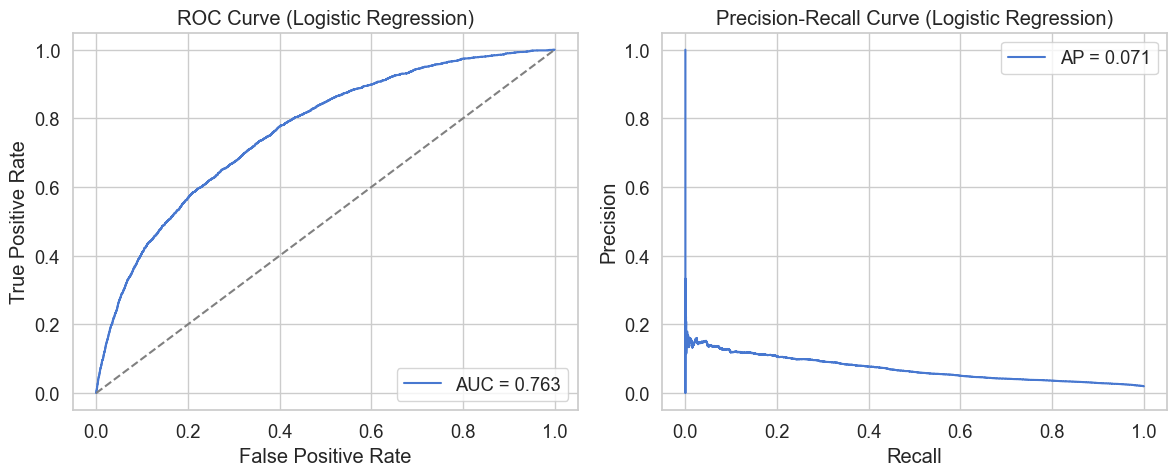

In [13]:
# Plot ROC and PR curves
fpr, tpr, _          = roc_curve(y_test, y_test_proba)
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)

plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.3f}')
plt.plot([0,1],[0,1],'--', color='grey')
plt.title('ROC Curve (Logistic Regression)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Precision Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'AP = {test_ap:.3f}')
plt.title('Precision-Recall Curve (Logistic Regression)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Linear SVM

In [14]:
MODEL_PATH   = "linear_svc_calibrated.joblib"
N_SPLITS     = 5
RANDOM_SEED  = 42
MAX_ITER = 10000

In [15]:
skf  = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
aucs = []
aps  = []

In [16]:
# Load existing model if available
if os.path.exists(MODEL_PATH):
    print("Loading existing model")
    svc_calibrated = load(MODEL_PATH)
else:
    print("Training model with 5 fold CV")

    # ─── 5-Fold CV ───
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_final_df, y_train), start=1):
        X_tr, X_val = X_train_final_df.iloc[train_idx], X_train_final_df.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx],           y_train.iloc[val_idx]

        # Train the base LinearSVC
        base_svc = LinearSVC(
            max_iter=MAX_ITER,
            class_weight='balanced',
            dual=False,
            random_state=RANDOM_SEED
        )
        base_svc.fit(X_tr, y_tr)

        # Calibrate probabilities on the validation fold
        calibrated = CalibratedClassifierCV(
            estimator=base_svc,
            method='sigmoid',
            cv=5
        )
        calibrated.fit(X_val, y_val)

        # Evaluate performance on the validation fold
        y_val_proba = calibrated.predict_proba(X_val)[:, 1]
        fold_auc = roc_auc_score(y_val, y_val_proba)
        fold_ap  = average_precision_score(y_val, y_val_proba)
        aucs.append(fold_auc)
        aps.append(fold_ap)

        print(f" Fold {fold}: AUC = {fold_auc:.3f}, AP = {fold_ap:.3f}")

    # Cross validation summary
    print(f"\nCV summary ({N_SPLITS} folds):")
    print(f"  Mean AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")
    print(f"  Mean AP : {np.mean(aps):.3f} ± {np.std(aps):.3f}")

    # Final training on full train set with calibration
    base_final = LinearSVC(
        max_iter=MAX_ITER,
        class_weight='balanced',
        dual=False,
        random_state=RANDOM_SEED
    )
    base_final.fit(X_train_final_df, y_train)

    svc_calibrated = CalibratedClassifierCV(
        estimator=base_final,
        method='sigmoid',
        cv=5
    )
    svc_calibrated.fit(X_train_final_df, y_train)

    dump(svc_calibrated, MODEL_PATH)
    print(f"Model saved to '{MODEL_PATH}'")

Loading existing model


In [17]:
# Evaluate on the test set
y_test_proba = svc_calibrated.predict_proba(X_test_final_df)[:, 1]
test_auc     = roc_auc_score(y_test, y_test_proba)
test_ap      = average_precision_score(y_test, y_test_proba)

print(f"\nTest set performance:")
print(f"  AUC = {test_auc:.3f}")
print(f"  AP  = {test_ap:.3f}")


Test set performance:
  AUC = 0.765
  AP  = 0.073


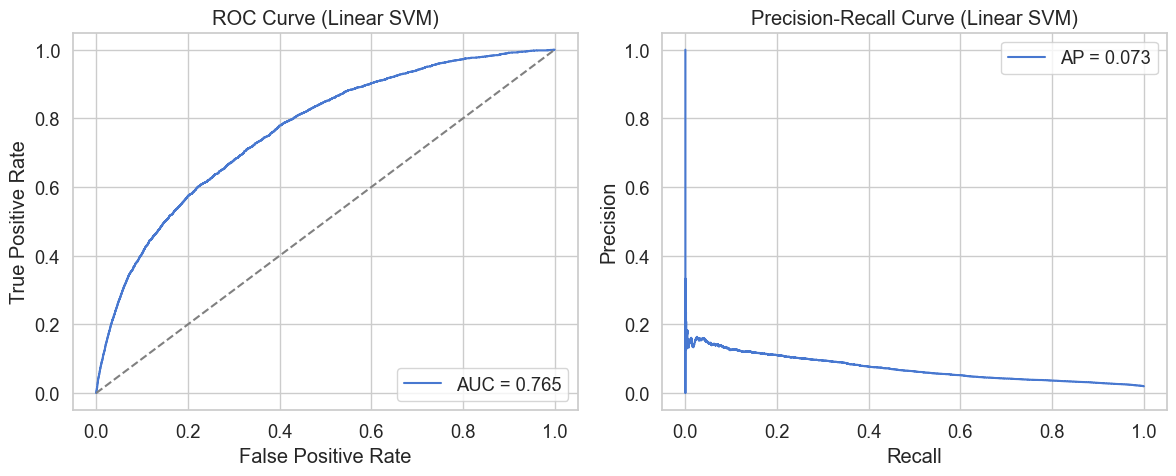

In [18]:
# Plot ROC and PR curves
fpr, tpr, _          = roc_curve(y_test, y_test_proba)
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)

plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.3f}')
plt.plot([0, 1], [0, 1], '--', color='grey')
plt.title('ROC Curve (Linear SVM)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Precision Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'AP = {test_ap:.3f}')
plt.title('Precision-Recall Curve (Linear SVM)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# One Class SVM

In [19]:
MODEL_PATH   = "oneclass_svm.joblib"
N_SPLITS     = 5 
RANDOM_SEED  = 42

In [20]:
skf  = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
aucs = []
aps  = []

In [21]:
# Load existing model if available
if os.path.exists(MODEL_PATH):
    print("Loading existing model")
    ocsvm = load(MODEL_PATH)
else:
    print("Training model with 5 fold CV")
    # ─── 5-Fold CV ───
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_final_df, y_train), start=1):
        X_tr, X_val = X_train_final_df.iloc[train_idx], X_train_final_df.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx],           y_train.iloc[val_idx]

        # Training only with GOODS (label 0)
        mask_good   = (y_tr.values == 0)
        X_tr_good   = X_tr.iloc[mask_good] 

        ocsvm = OneClassSVM(gamma='auto', nu=0.02)
        ocsvm.fit(X_tr_good)

        # Invert score: higher score = more anomaly
        scores = -ocsvm.decision_function(X_val)
        fold_auc = roc_auc_score(y_val, scores)
        fold_ap  = average_precision_score(y_val, scores)
        aucs.append(fold_auc)
        aps.append(fold_ap)

        print(f" Fold {fold}: AUC = {fold_auc:.3f}, AP = {fold_ap:.3f}")

    # Summary of cross validation results
    print(f"\nCV summary ({N_SPLITS} folds):")
    print(f"  Mean AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")
    print(f"  Mean AP : {np.mean(aps):.3f} ± {np.std(aps):.3f}")

    # Train final model on all available 'good' samples
    mask_all_good = (y_train.values == 0)
    X_train_good  = X_train_final_df.iloc[mask_all_good]
    ocsvm = OneClassSVM(gamma='auto', nu=0.02)
    ocsvm.fit(X_train_good)
    dump(ocsvm, MODEL_PATH)
    print(f"Model saved to '{MODEL_PATH}'")

Loading existing model


In [22]:
# Evaluate on the test set
scores_test = -ocsvm.decision_function(X_test_final_df)
test_auc   = roc_auc_score(y_test, scores_test)
test_ap    = average_precision_score(y_test, scores_test)

print(f"\nTest set performance:")
print(f"  AUC = {test_auc:.3f}")
print(f"  AP  = {test_ap:.3f}")


Test set performance:
  AUC = 0.550
  AP  = 0.029


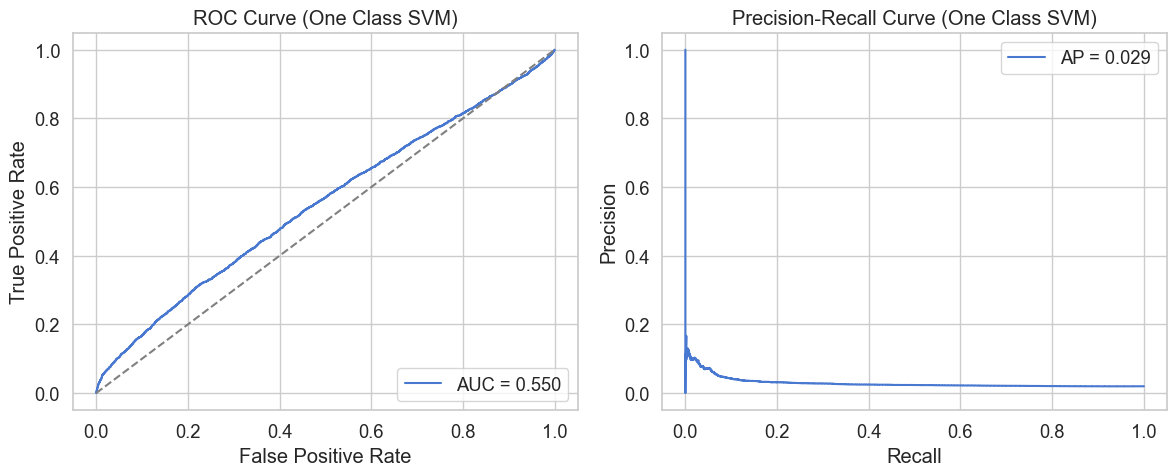

In [23]:
# Plot ROC and PR curves
fpr, tpr, _          = roc_curve(y_test, scores_test)
precision, recall, _ = precision_recall_curve(y_test, scores_test)

plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.3f}')
plt.plot([0, 1], [0, 1], '--', color='grey')
plt.title('ROC Curve (One Class SVM)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Precision Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'AP = {test_ap:.3f}')
plt.title('Precision-Recall Curve (One Class SVM)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Isolation Forest

In [28]:
# Parameters
MODEL_PATH   = "isolation_forest.joblib"
N_SPLITS     = 5
RANDOM_SEED  = 42
CONTAMINATION = 0.02  # expected proportion of anomalies

In [29]:
skf  = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
aucs = []
aps  = []

In [30]:
# Load existing model if available
if os.path.exists(MODEL_PATH):
    print("Loading existing model")
    iso = load(MODEL_PATH)
else:
    print("Training model with 5 fold CV")
    # ─── 5-Fold CV ───
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_final_df, y_train), start=1):
        X_tr, X_val = X_train_final_df.iloc[train_idx], X_train_final_df.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx],           y_train.iloc[val_idx]

        # Training only with GOODS (label 0)
        mask_good   = (y_tr.values == 0)
        X_tr_good   = X_tr.iloc[mask_good]  
        iso = IsolationForest(
            n_estimators=100,
            contamination=CONTAMINATION,
            random_state=RANDOM_SEED
        )
        iso.fit(X_tr_good)

        # Invert score: higher score = more anomaly
        scores = -iso.decision_function(X_val)
        fold_auc = roc_auc_score(y_val, scores)
        fold_ap  = average_precision_score(y_val, scores)
        aucs.append(fold_auc)
        aps.append(fold_ap)

        print(f" Fold {fold}: AUC = {fold_auc:.3f}, AP = {fold_ap:.3f}")

    # Summary of cross validation results
    print(f"\nCV summary ({N_SPLITS} folds):")
    print(f"  Mean AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")
    print(f"  Mean AP : {np.mean(aps):.3f} ± {np.std(aps):.3f}")

    # Train final model on all available 'good' samples
    mask_all_good = (y_train.values == 0)
    X_train_good  = X_train_final_df.iloc[mask_all_good]
    iso = IsolationForest(
        n_estimators=100,
        contamination=CONTAMINATION,
        random_state=RANDOM_SEED
    )
    iso.fit(X_train_good)
    dump(iso, MODEL_PATH)
    print(f"Model saved to '{MODEL_PATH}'")

Loading existing model


In [31]:
# Evaluate on the test set
scores_test = -iso.decision_function(X_test_final_df)
test_auc   = roc_auc_score(y_test, scores_test)
test_ap    = average_precision_score(y_test, scores_test)

print(f"\nTest set performance:")
print(f"  AUC = {test_auc:.3f}")
print(f"  AP  = {test_ap:.3f}")


Test set performance:
  AUC = 0.586
  AP  = 0.027


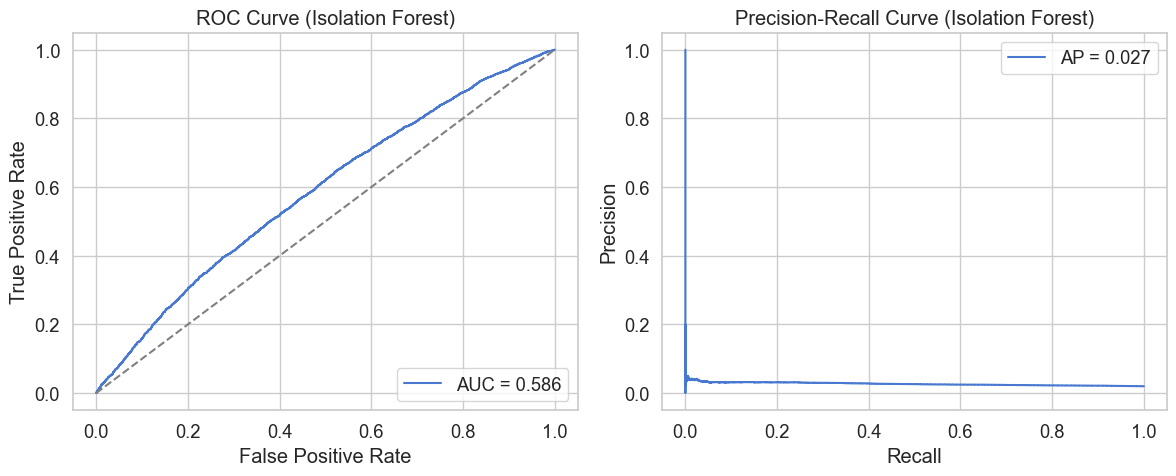

In [32]:
# Plot ROC and PR curves
fpr, tpr, _          = roc_curve(y_test, scores_test)
precision, recall, _ = precision_recall_curve(y_test, scores_test)

plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.3f}')
plt.plot([0, 1], [0, 1], '--', color='grey')
plt.title('ROC Curve (Isolation Forest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Precision Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'AP = {test_ap:.3f}')
plt.title('Precision-Recall Curve (Isolation Forest)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Approximate Polytope Ensemble

In [33]:
# Remap labels for APE: 0 (good) = 1, 1 (bad) = -1
y_train_ape = y_train.map({0: 1, 1: -1})
y_test_ape  = y_test.map({0: 1, 1: -1})

## APE Class Definition

In [34]:
class APE_base():
    def __init__(self,**kwargs):
        self.__dict__=kwargs

class APE(BaseEstimator):
    def __init__(self, n_proj=100, target=1., frac=0.01):
        np.random.seed(0)
        self.n_proj = n_proj # Number of projections
        self.target = target # Target class for projection
        self.frac = frac # Fraction of training samples to use for each projection
        self.ape = []
        self.oape = []

    def _in_hull(self, p, hull):
        # Check if each point lies inside the convex hull
        ic = np.zeros((p.shape[0],))
        for equation in hull.equations:
            n = equation[0:2]
            o = equation[2]
            ic += np.where(np.dot(n, p.T) + o > 1e-6, 1, 0)
        return ic <= 0

    def fit(self, X, y):
        ape = []
        N = X.shape[0]
        self.ratio_outside = np.zeros(N)
        self.stats_ = {
            "seen": np.zeros(N),
            "outhull": np.zeros(N)
        }
        self.oape = []

        for t in range(self.n_proj):
            idx_subset = np.random.choice(N, size=int(self.frac * N), replace=False)
            X_subset = X.iloc[idx_subset]
            y_subset = y.iloc[idx_subset].squeeze().to_numpy()

            clf = APE_base()
            clf.P = np.random.randn(X.shape[1], 2) # Random projection matrix
            clf.P[:, 0] /= np.linalg.norm(clf.P[:, 0])            
            clf.P[:, 1] -= np.dot(clf.P[:, 1], clf.P[:, 0]) * clf.P[:, 0]
            clf.P[:, 1] /= np.linalg.norm(clf.P[:, 1])

            X_proj = np.dot(X_subset[y_subset == self.target], clf.P)
            clf.hull = ConvexHull(X_proj)
            self.oape.append(clf)

            # Save statistics in absolute indices
            X_proj_all = np.dot(X.iloc[idx_subset], clf.P)
            in_mask = self._in_hull(X_proj_all, clf.hull)
            self.stats_["seen"][idx_subset] += 1
            self.stats_["outhull"][idx_subset] += ~in_mask

        return self

    def score_samples(self, X):
        # Compute how often each sample falls outside the hulls
        ratio = np.zeros(X.shape[0])
        seen = np.zeros(X.shape[0])
        outhull = np.zeros(X.shape[0])

        for clf in self.oape:
            X_proj = np.dot(X, clf.P)
            in_mask = self._in_hull(X_proj, clf.hull)
            seen += 1
            outhull += ~in_mask

        ratio = np.divide(outhull, seen, out=np.zeros_like(outhull), where=seen > 0)
        return ratio

    def predict(self, X):
        # Predict +1 if never outside, -1 if outside at least once
        scores = self.score_samples(X)
        return np.where(scores == 0, 1., -1.)

In [35]:
# Parameters
MODEL_PATH   = "ape.joblib"
N_SPLITS     = 5 
RANDOM_SEED  = 42

In [36]:
skf  = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
aucs = []
aps  = []

In [37]:
# Load existing model if available
if os.path.exists(MODEL_PATH):
    print("Loading existing model")
    ape = load(MODEL_PATH)
else:
    print("Training model with 5 fold CV")
    # ─── 5-Fold CV ───
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_final_df, y_train_ape), start=1):
        X_tr, X_val = X_train_final_df.iloc[train_idx], X_train_final_df.iloc[val_idx]
        y_tr, y_val = y_train_ape.iloc[train_idx], y_train_ape.iloc[val_idx]

        model = APE(n_proj=100000, frac=0.01)
        model.fit(X_tr, y_tr)

        scores = model.score_samples(X_val)
        auc = roc_auc_score(y_val, scores)
        ap  = average_precision_score(y_val, scores)
        aucs.append(auc)
        aps.append(ap)

        print(f"Fold {fold}: AUC = {auc:.3f}, AP = {ap:.3f}")

    # Cross validation summary
    print(f"\nCV summary ({N_SPLITS} folds):")
    print(f"  Mean AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")
    print(f"  Mean AP : {np.mean(aps):.3f} ± {np.std(aps):.3f}")

    # Final training on the full set
    ape = APE(n_proj=100000, frac=0.01, target=1) 
    ape.fit(X_train_final_df, y_train_ape)
    dump(ape, MODEL_PATH)
    print(f"Model saved to '{MODEL_PATH}'")

Loading existing model


In [38]:
# Evaluate on the test set
scores_test = ape.score_samples(X_test_final_df) 
fpr, tpr, _ = roc_curve(y_test_ape, scores_test, pos_label=-1)
test_auc = auc(fpr, tpr)
test_ap  = average_precision_score(y_test_ape, scores_test, pos_label=-1)

print(f"\nTest set performance:")
print(f"  AUC = {test_auc:.3f}")
print(f"  AP  = {test_ap:.3f}")


Test set performance:
  AUC = 0.564
  AP  = 0.026


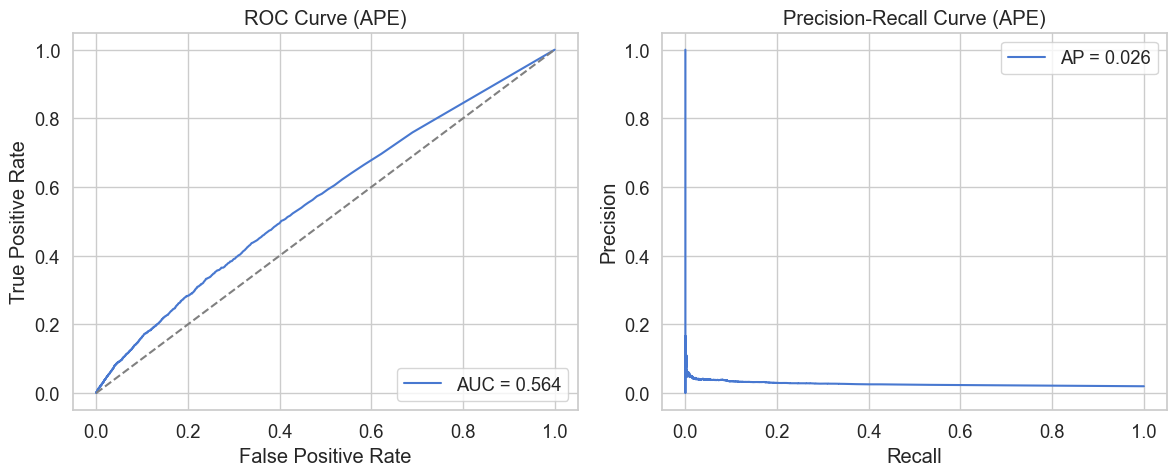

In [39]:
# Plot ROC and PR curves
fpr, tpr, _          = roc_curve(y_test_ape, scores_test, pos_label=-1)
precision, recall, _ = precision_recall_curve(y_test_ape, scores_test, pos_label=-1)

plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.3f}')
plt.plot([0,1],[0,1],'--', color='grey')
plt.title('ROC Curve (APE)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Precision-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'AP = {test_ap:.3f}')
plt.title('Precision-Recall Curve (APE)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Model Comparison on Test Set

In [40]:
# Load saved models
logreg  = load('logreg_model.joblib')
svm_lin = load('linear_svc_calibrated.joblib')
ocsvm   = load('oneclass_svm.joblib')
iso     = load('isolation_forest.joblib')
ape     = load('ape.joblib')

# Dictionary of models
models = {
    'Logistic Regression': logreg,
    'Linear SVM':          svm_lin,
    'One-Class SVM':       ocsvm,
    'Isolation Forest':    iso,
    'APE':                 ape
}

In [41]:
# Compute anomaly or probability scores on test set
scores = {}

for name, model in models.items():
    if name in ['Logistic Regression', 'Linear SVM']:
        scores[name] = model.predict_proba(X_test_final_df)[:, 1]
    elif name == 'APE':
        scores[name] = model.score_samples(X_test_final_df)
    else:
        scores[name] = -model.decision_function(X_test_final_df)


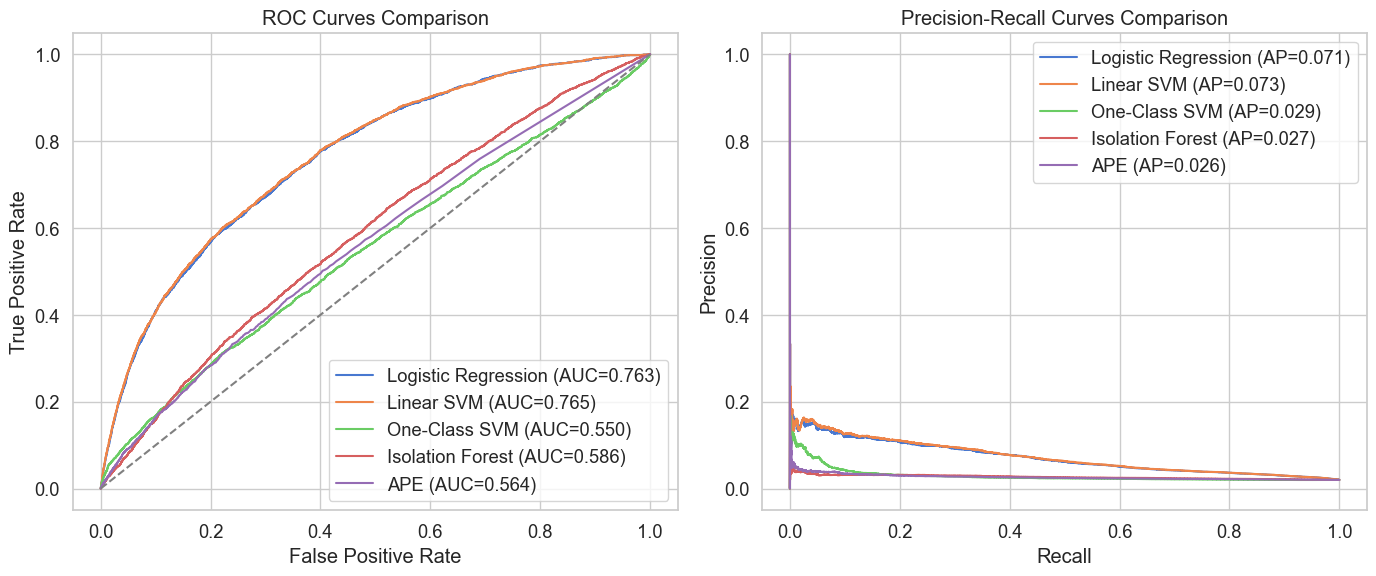

In [42]:
fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curves
for name, y_score in scores.items():
    if name == 'APE':
        fpr, tpr, _ = roc_curve(y_test_ape, y_score, pos_label=-1)
        roc_auc = auc(fpr, tpr)
    else:
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
    ax_roc.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.3f})')
ax_roc.plot([0, 1], [0, 1], '--', color='grey')
ax_roc.set_title('ROC Curves Comparison')
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.legend(loc='lower right')

# Precision-Recall Curves
for name, y_score in scores.items():
    if name == 'APE':
        precision, recall, _ = precision_recall_curve(y_test_ape, y_score, pos_label=-1)
        ap = average_precision_score(y_test_ape, y_score, pos_label=-1)
    else:
        precision, recall, _ = precision_recall_curve(y_test, y_score)
        ap = average_precision_score(y_test, y_score)
    ax_pr.plot(recall, precision, label=f'{name} (AP={ap:.3f})')
ax_pr.set_title('Precision-Recall Curves Comparison')
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Phase 3.2 - Hybrid Modelling with Anomaly Based Features

Again, we applied the hybrid strategy, but now considering the full features set.

In [43]:
# Load One Class models trained
ocsvm_path = 'oneclass_svm.joblib'
iso_path   = 'isolation_forest.joblib'
ape_path   = 'ape.joblib'

if not all(os.path.exists(p) for p in [ocsvm_path, iso_path, ape_path]):
    raise FileNotFoundError("One or more One-Class model files are missing.")

In [44]:
ocsvm = load(ocsvm_path)
iso   = load(iso_path)
ape   = load(ape_path)

In [45]:
# Generate anomaly based features
scores_ocsvm_train = -ocsvm.decision_function(X_train_final_df)
scores_iso_train   = -iso.decision_function(X_train_final_df)
scores_ape_train   = ape.score_samples(X_train_final_df)

scores_ocsvm_test = -ocsvm.decision_function(X_test_final_df)
scores_iso_test   = -iso.decision_function(X_test_final_df)
scores_ape_test   = ape.score_samples(X_test_final_df)

In [46]:
# Add anomaly scores to training and test sets
X_train_stack = X_train_final_df.copy()
X_train_stack['score_ocsvm'] = scores_ocsvm_train
X_train_stack['score_iso']   = scores_iso_train
X_train_stack['score_ape']   = scores_ape_train

X_test_stack = X_test_final_df.copy()
X_test_stack['score_ocsvm'] = scores_ocsvm_test
X_test_stack['score_iso']   = scores_iso_test
X_test_stack['score_ape']   = scores_ape_test

In [47]:
# Train or Load Hybrid Models
LR_STACK_PATH  = "lr_stack_model.joblib"
SVC_STACK_PATH = "svc_stack_model.joblib"

if os.path.exists(LR_STACK_PATH):
    print("Loading existing stacked Logistic Regression model")
    lr_stack = load(LR_STACK_PATH)
else:
    print("Training Logistic Regression stacked model")
    lr_stack = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
    lr_stack.fit(X_train_stack, y_train)
    dump(lr_stack, LR_STACK_PATH)
    print(f"LR model saved to '{LR_STACK_PATH}'")

if os.path.exists(SVC_STACK_PATH):
    print("Loading existing stacked Linear SVM model")
    svc_stack = load(SVC_STACK_PATH)
else:
    print("Training Linear SVM stacked model")
    base_svc_stack = LinearSVC(max_iter=5000, class_weight='balanced', dual=False, random_state=42)
    base_svc_stack.fit(X_train_stack, y_train)
    svc_stack = CalibratedClassifierCV(estimator=base_svc_stack, method='sigmoid', cv=5)
    svc_stack.fit(X_train_stack, y_train)
    dump(svc_stack, SVC_STACK_PATH)
    print(f"Linear SVM saved to '{SVC_STACK_PATH}'")

Training Logistic Regression stacked model
LR model saved to 'lr_stack_model.joblib'
Training Linear SVM stacked model
Linear SVM saved to 'svc_stack_model.joblib'


In [48]:
# Evaluate on test
y_lr_proba  = lr_stack.predict_proba(X_test_stack)[:, 1]
y_svc_proba = svc_stack.predict_proba(X_test_stack)[:, 1]

lr_auc  = roc_auc_score(y_test, y_lr_proba)
lr_ap   = average_precision_score(y_test, y_lr_proba)
svc_auc = roc_auc_score(y_test, y_svc_proba)
svc_ap  = average_precision_score(y_test, y_svc_proba)

In [49]:
print("\nTest set performance with anomaly scores:")
print(f"Logistic Regression + anomaly scores → AUC: {lr_auc:.3f}, AP: {lr_ap:.3f}")
print(f"Linear SVM + anomaly scores → AUC: {svc_auc:.3f}, AP: {svc_ap:.3f}")


Test set performance with anomaly scores:
Logistic Regression + anomaly scores → AUC: 0.762, AP: 0.071
Linear SVM + anomaly scores → AUC: 0.765, AP: 0.073


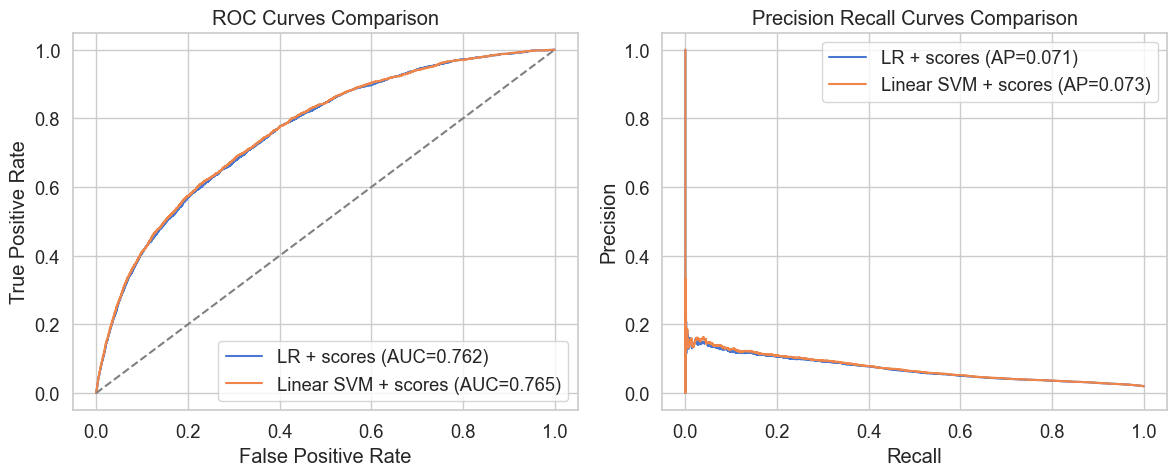

In [50]:
# Plot ROC and Precision-Recall Curves
fpr_lr, tpr_lr, _     = roc_curve(y_test, y_lr_proba)
prec_lr, rec_lr, _    = precision_recall_curve(y_test, y_lr_proba)
fpr_svc, tpr_svc, _   = roc_curve(y_test, y_svc_proba)
prec_svc, rec_svc, _  = precision_recall_curve(y_test, y_svc_proba)

plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
plt.plot(fpr_lr, tpr_lr, label=f'LR + scores (AUC={lr_auc:.3f})')
plt.plot(fpr_svc, tpr_svc, label=f'Linear SVM + scores (AUC={svc_auc:.3f})')
plt.plot([0, 1], [0, 1], '--', color='grey')
plt.title('ROC Curves Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# PR
plt.subplot(1, 2, 2)
plt.plot(rec_lr, prec_lr, label=f'LR + scores (AP={lr_ap:.3f})')
plt.plot(rec_svc, prec_svc, label=f'Linear SVM + scores (AP={svc_ap:.3f})')
plt.title('Precision Recall Curves Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()